In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [4]:
# Get the dependancy tags from text using sPaCy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [5]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [6]:
candidate_sentences['sentence'].sample(5)

2650    shaggy was set to be a stoner, velma and daphne had a side relationship,  and there were many  marijuana references.
3998                                                                                   chris espinosa stated on twitter, fyi
2806                                                                                        this youngster was like camphor.
3407                                                                                             like he did tatsumichi oki.
2896                                                        their first cut of the film ran three hours and 20 minutes long.
Name: sentence, dtype: object

In [9]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


Process is the subject and d823 is the object

In [10]:
#Entity Extraction using sPaCy dependencies. Take out subject and object
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [11]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [12]:

entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))
  

100%|██████████| 4318/4318 [00:37<00:00, 115.67it/s]


In [23]:
#Relation/Predicate Extraction

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP':'ROOT'}], 
            [{'DEP':'prep','OP':"?"}],
            [{'DEP':'agent','OP':"?"}],  
            [{'POS':'ADJ','OP':"?"}]] 

  matcher.add("matching_1", pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)


In [24]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

In [25]:
pd.Series(relations).value_counts()[:50]

in               438
by               331
on               225
of               197
for              101
to                96
with              72
as                69
at                50
from              43
was               42
include           29
first             28
is                25
international     24
other             21
into              20
about             20
new               19
released          19
positive          19
are               18
different         17
original          17
have              17
mixed             16
several           15
best              15
commercial        15
than              15
has               14
were              14
special           14
more              14
indian            12
many              12
during            12
popular           12
like              12
had               11
national          11
produced          11
included          10
imax              10
critical           9
few                9
since              9
includes     

In [26]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [27]:
# create a directed-graph from a dataframe using networkx
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

  6%|▌         | 256/4318 [07:42<2:02:16,  1.81s/it]


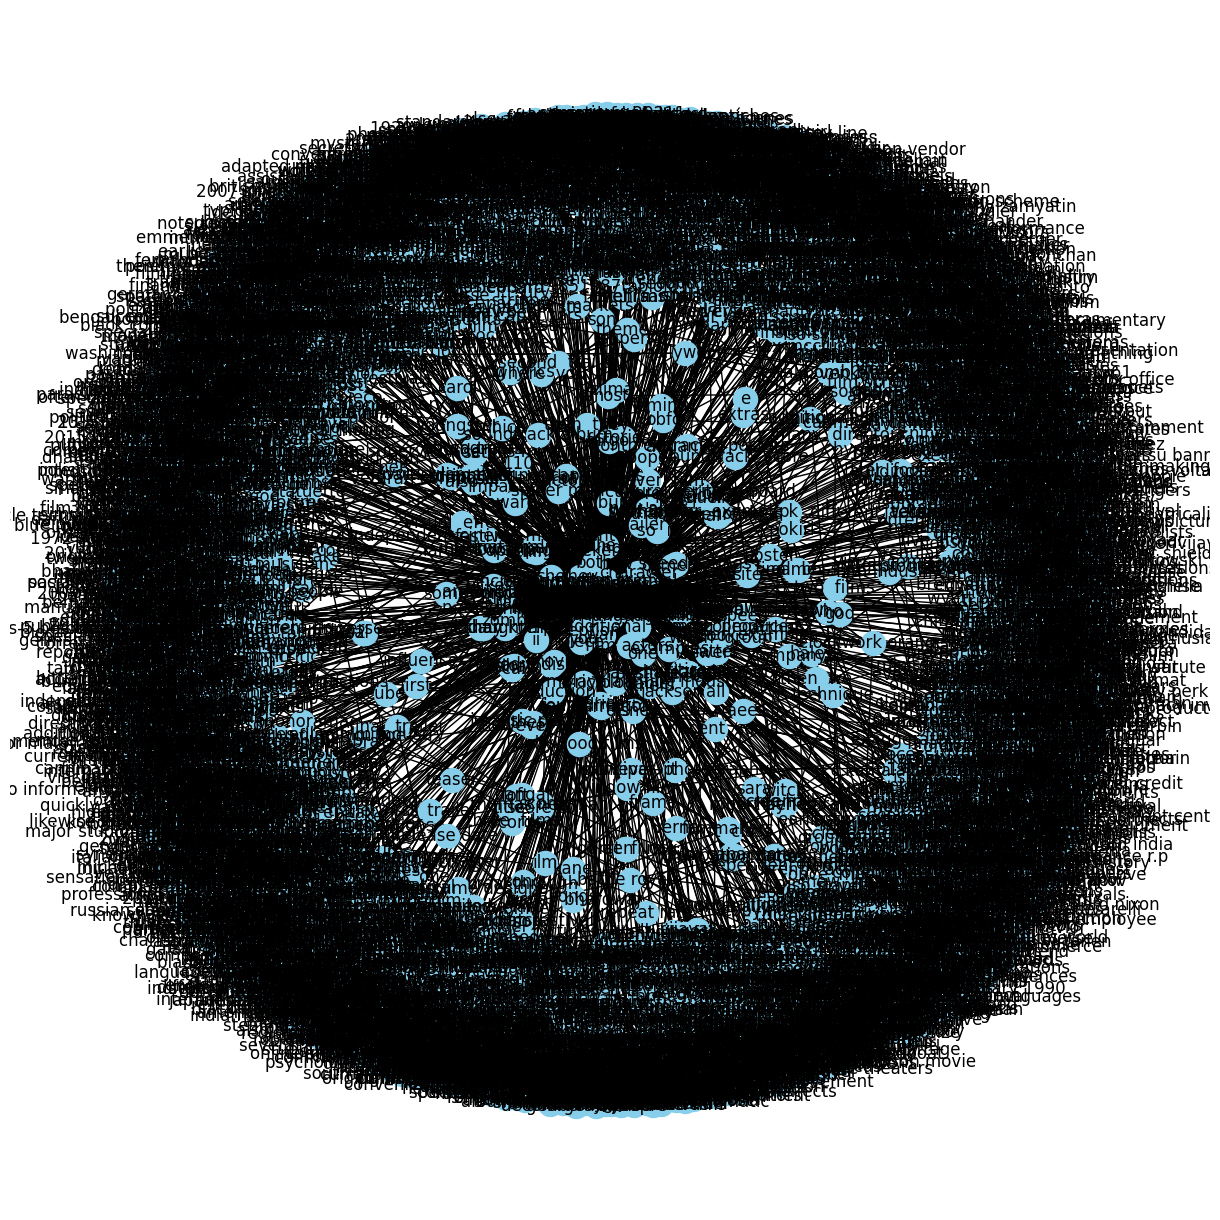

In [28]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [30]:
plt.clf()

<Figure size 640x480 with 0 Axes>

In [36]:
kg_df.head

<bound method NDFrame.head of                  source                           target       edge
0                connie                              own        own
1         later  scream                         distance         in
2             christian                      then  elder         by
3                temple                             fire         on
4                                       outside cult him       with
...                 ...                              ...        ...
4313       confidencial                 negatively  film  indulgent
4314        le parisien                 five star rating    highest
4315  museum collection               37,000 film titles   includes
4316        predecessor             historical film 1946         in
4317                     1920'sfilmstar alexander binder         by

[4318 rows x 3 columns]>

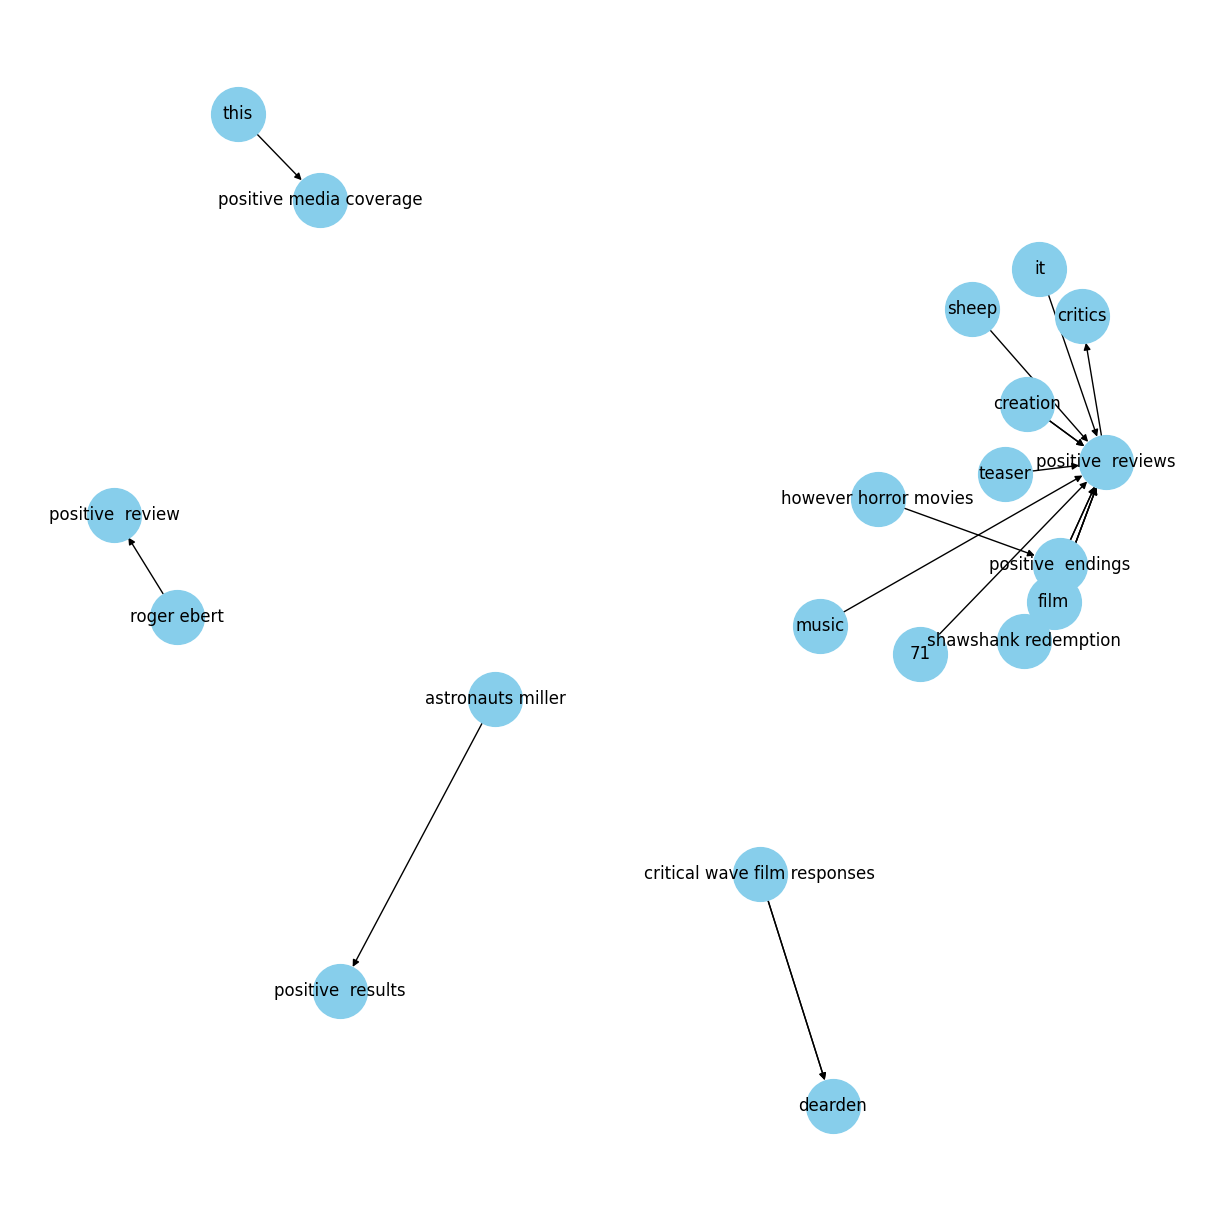

In [41]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="positive"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

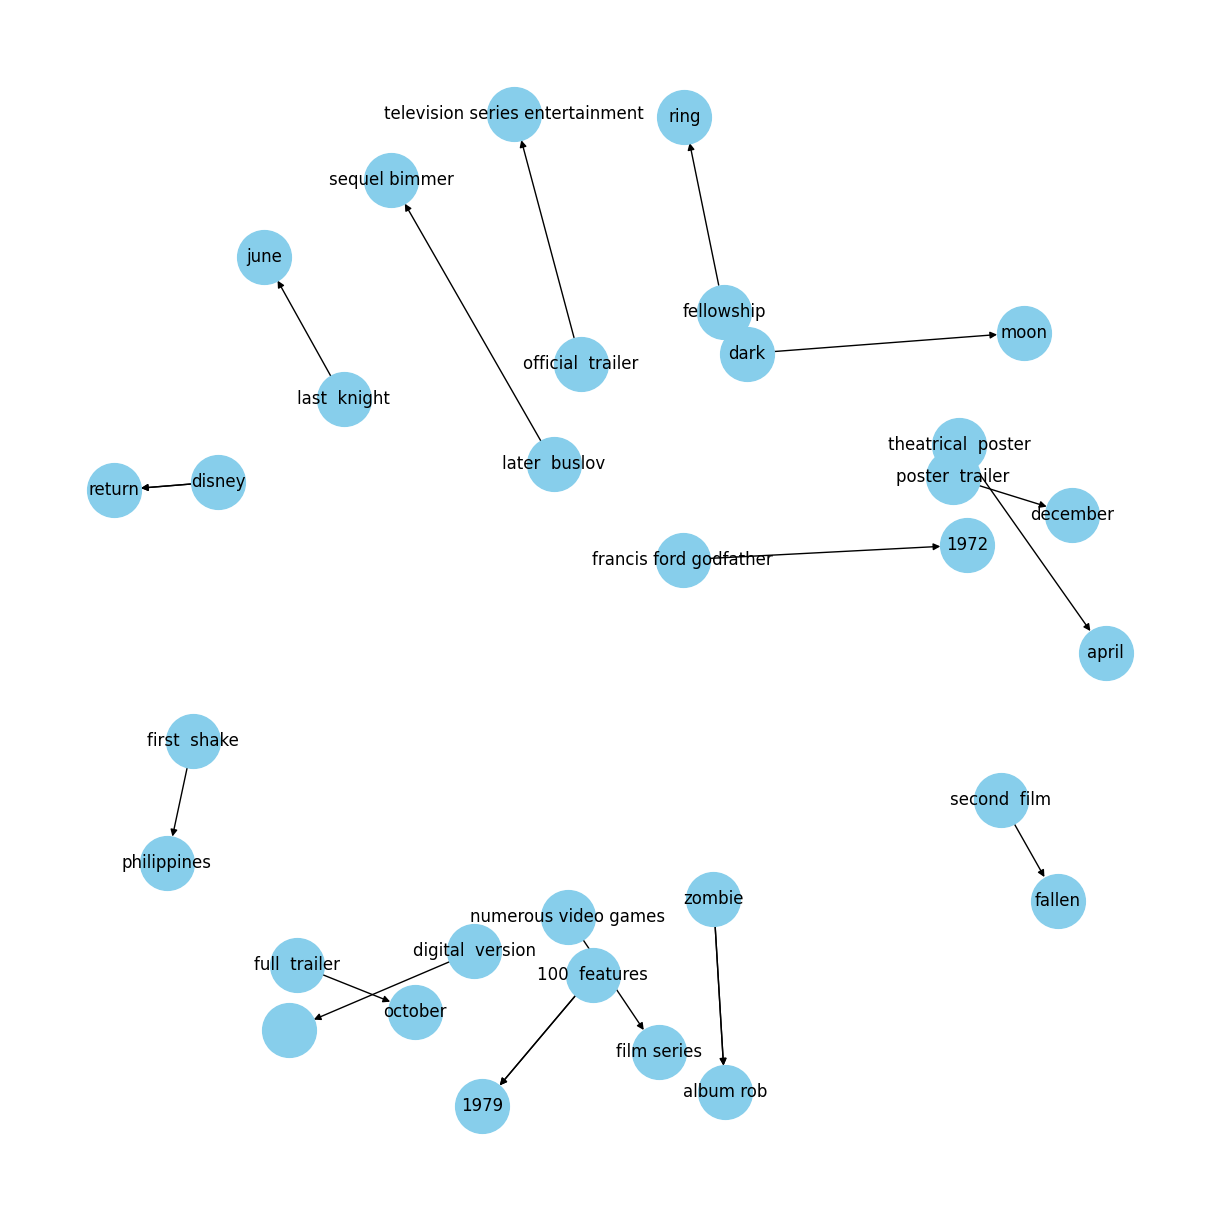

In [43]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()